In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.optimizers import Adam

from gpu.negfc_models import get_model_new
from gpu.losses import reduce_std, wrapper
from gpu.data import load_data
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

2023-05-19 20:25:24.680507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 20:25:25.545857: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/users/cdonoso/miniconda3/envs/tf2/lib/:/home/users/cdonoso/miniconda3/envs/tf2/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-05-19 20:25:25.545927: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH:

In [2]:
%%time
root='./data/fake/'
dataset, cube_shp, init_xy, init_flux = load_data(root, 
                                                  bkg_sigma=5, 
                                                  ncomp=1, 
                                                  num_peaks=10,
                                                  normalize=False,
                                                  psf_pos=0,
                                                  )

2023-05-19 20:25:33.778178: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-05-19 20:25:33.780794: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-05-19 20:25:33.780845: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
CPU times: user 9.53 s, sys: 2.65 s, total: 12.2 s
Wall time: 12.7 s


In [3]:
# import tensorflow as tf

# def create_circle_mask(coordinates, w, h, r):
#     # Create a grid of coordinates
#     grid_x, grid_y = tf.meshgrid(tf.range(w), tf.range(h))

#     # Expand dimensions to match the input coordinates
#     expanded_grid_x = tf.expand_dims(grid_x, axis=-1)
#     expanded_grid_y = tf.expand_dims(grid_y, axis=-1)

#     # Calculate the squared distance from each point to the coordinates
#     dist_sq = tf.square(expanded_grid_x - coordinates[:, 0]) + tf.square(expanded_grid_y - coordinates[:, 1])

#     # Create the mask by comparing the squared distance to the radius squared
#     mask = tf.cast(dist_sq <= r**2, dtype=tf.float32)

#     return mask

# # Example usage:
# coordinates = tf.constant([[50, 50], [70, 80], [30, 40]])
# w = 100
# h = 100
# r = 30

# circle_mask = create_circle_mask(coordinates, w, h, r)
# print(circle_mask.shape)
# plt.imshow(circle_mask)


In [4]:
# model = get_model_new(init_xy, init_flux, cube_shp)
# loss_fn = wrapper(reduce_std, nfwhm=2, debug=True, minimize='std')
# for x, y in dataset:
    
#     pred = model(x)
    
#     red = loss_fn(y, pred)
    
    
#     fig, axes = plt.subplots(3,3,dpi=300, sharex=True, sharey=True,
#                             gridspec_kw={'hspace': 0., 'wspace': -0.4})
#     axes = axes.flatten()
#     for i, N in enumerate(range(0, 9)):        
#         axes[i].imshow(red[0,N])
# #         axes[i].imshow(y['cube'][0,N], alpha=.5)

In [25]:
angle = 120. 
r = 250.

In [32]:
model = get_model_new(init_xy, init_flux, cube_shp)
loss_fn = wrapper(reduce_std, nfwhm=5, debug=False, minimize='sum')
model.compile(loss_fn=loss_fn, 
              optimizer=tf.keras.optimizers.RMSprop(1))

In [34]:
## %%time
es = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=50,# min_delta=1e-5
)
hist = model.fit(dataset, epochs=100000, callbacks=[es])

Epoch 1/100000
[385.645233 727.778564]
158.231842
1/1 [==============================] - 0s 64ms/step - loss: 120.7658
Epoch 2/100000
[385.645233 727.778564]
-158.231842
1/1 [==============================] - 0s 65ms/step - loss: 37.4661
Epoch 3/100000
[385.645233 727.778564]
158.231842
1/1 [==============================] - 0s 64ms/step - loss: 120.7658
Epoch 4/100000
[385.645233 727.778564]
-158.231842
1/1 [==============================] - 0s 59ms/step - loss: 37.4661
Epoch 5/100000
[385.645233 727.778564]
158.231842
1/1 [==============================] - 0s 65ms/step - loss: 120.7658
Epoch 6/100000
[385.645233 727.778564]
-158.231842
1/1 [==============================] - 0s 65ms/step - loss: 37.4661
Epoch 7/100000
[385.645233 727.778564]
158.231842
1/1 [==============================] - 0s 65ms/step - loss: 120.7658
Epoch 8/100000
[385.645233 727.778564]
-158.231842
1/1 [==============================] - 0s 58ms/step - loss: 37.4661
Epoch 9/100000
[385.645233 727.778564]
158.23184

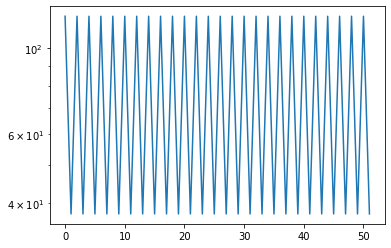

In [37]:
plt.plot(hist.history['loss'])
plt.yscale('log')

In [36]:
x_fguess = model.trainable_variables[0]
y_fguess = model.trainable_variables[1]
f_fguess = model.trainable_variables[2]
print(init_flux, init_xy)
x_fguess[0][0], y_fguess[0][0], f_fguess[0][0]

[130.46871932] [[385.64523 727.77856]]


(<tf.Tensor: shape=(), dtype=float32, numpy=385.64523>,
 <tf.Tensor: shape=(), dtype=float32, numpy=727.77856>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-270.673>)

In [30]:
import gpu.fake_comp as tfnegfc
from main import open_fits
import numpy as np

In [31]:
cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 
if tf.rank(cube) < 4:
    cube = cube[None,...]
psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)
if psf.shape[-1] % 2 == 0:
    psf = psf[..., :-1, :-1]
ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

Fits HDU-0 data successfully loaded. Data shape: (80, 1023, 1023)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (80,)


In [14]:
injected_cube = tfnegfc.inject_fake(x_fguess[0], 
                                    y_fguess[0], 
                                    np.median(f_fguess[0]), 
                                    np.zeros_like(cube[0]), 
                                    patch, 
                                    rot_ang)

<tf.Variable 'MoveScale/flux:0' shape=(1, 1) dtype=float32, numpy=array([[-192.49214]], dtype=float32)>

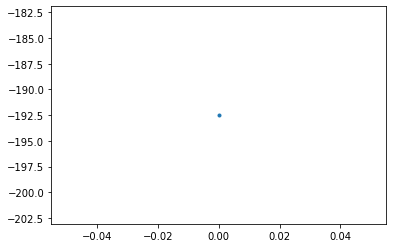

In [15]:
plt.plot(f_fguess[0], '.')
f_fguess

In [16]:
np.median(f_fguess[0])

-192.49214

In [17]:
%%time
adi_image = tfnegfc.apply_adi(cube[0], 
                              rot_ang, 
                              out_size=cube[0].shape, 
                              ncomp=2, 
                              derotate='tf', 
                              return_cube=False)

adi_image_fake = tfnegfc.apply_adi(injected_cube, 
                                   rot_ang, 
                                   out_size=injected_cube.shape, 
                                   ncomp=2, 
                                   derotate='tf', return_cube=False)

CPU times: user 1.16 s, sys: 1.39 s, total: 2.55 s
Wall time: 2.56 s


(700.0, 800.0)

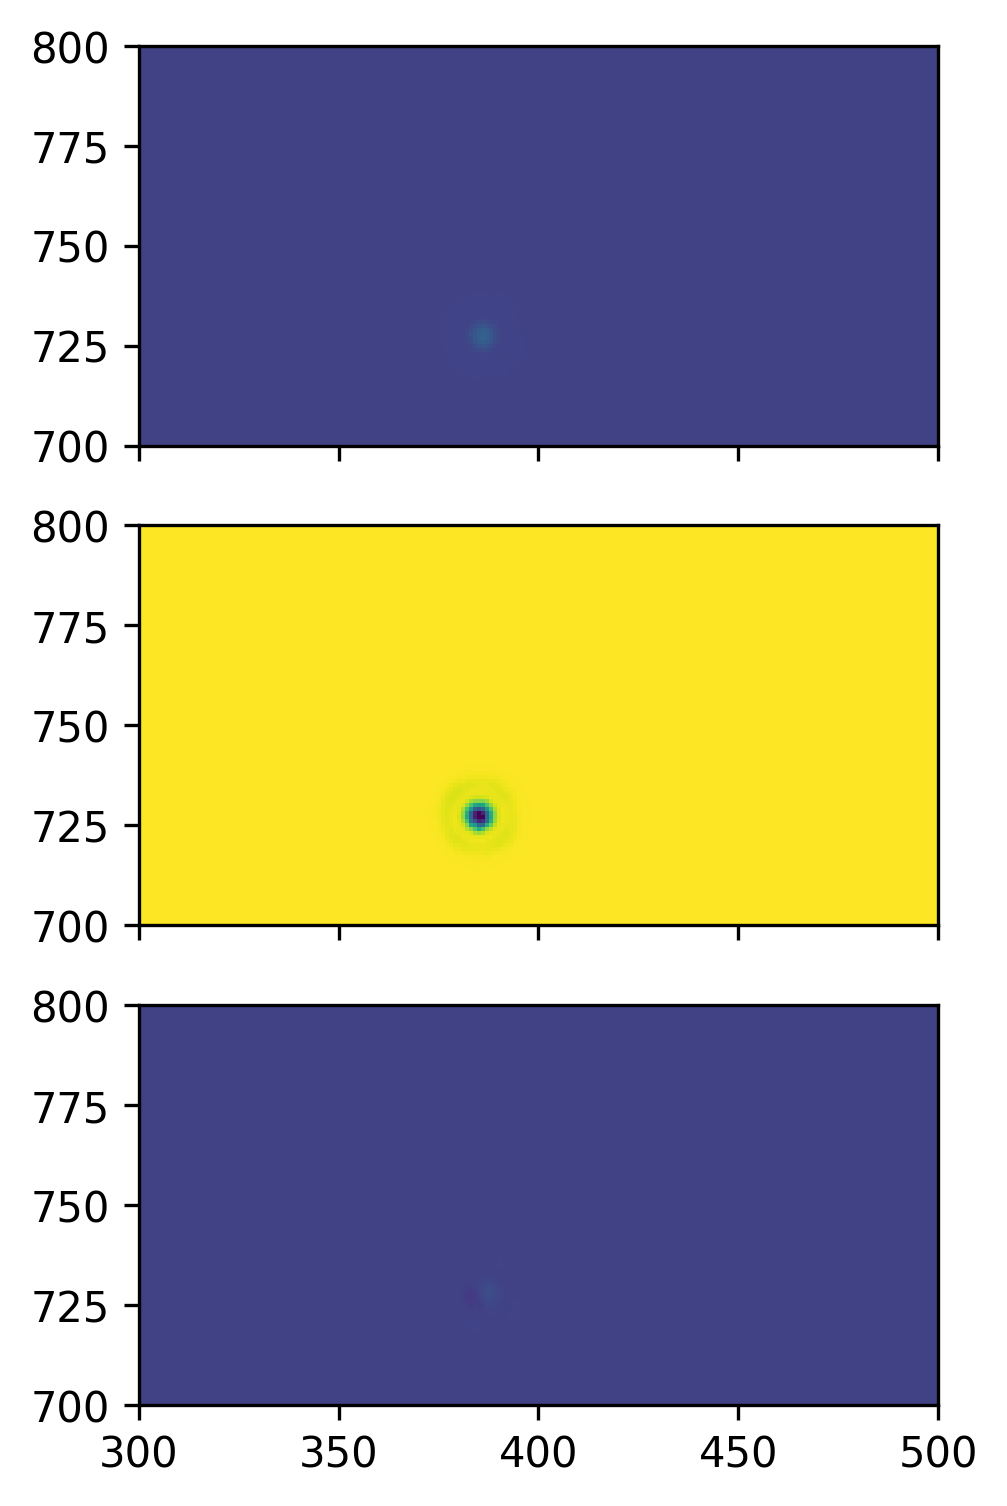

In [18]:
fig, axes = plt.subplots(3, 1, dpi=300, figsize=(6,6), sharex=True, sharey=True)
axes[0].imshow(adi_image)
axes[1].imshow(adi_image_fake)
axes[2].imshow(adi_image+adi_image_fake)
axes[2].set_xlim(300,500)
axes[2].set_ylim(700,800)